In [2]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

torch.manual_seed(42)

## Various sine function

In [3]:
# a random complex tensor of size (3,2,4):
x = torch.randn(3, 2, 4, dtype=torch.complex64)

In [4]:
T = 0.1024
fs = 5000
# meaning n_samples = T * fs = 0.1024 * 5000 = 512 (same as our windowed data)
frequencies = [20, 90]  # Hz
t = torch.arange(0, T, 1 / fs)
L = len(t)

#### sum of sines

In [5]:
sine_wave = torch.zeros_like(t)
for freq in frequencies:
    sine_wave += torch.sin(2 * np.pi * freq * t)

#### changing freq

In [6]:
transition_point = int(0.5 * L)  # Number of samples before frequency transition
changing_sine = torch.zeros_like(t)
changing_sine[:transition_point] = torch.sin(2 * torch.pi * frequencies[0] * t[:transition_point])
changing_sine[transition_point:] = torch.sin(2 * torch.pi * frequencies[-1] * t[transition_point:])

#### chirp

In [7]:
f0 = frequencies[0]  # starting frequency in Hz
fn = frequencies[-1]  # ending frequency in Hz
t = torch.linspace(0, T, int(T * fs), dtype=torch.float32)
omega = 2 * torch.pi * (f0 + (fn - f0) * t / T)
chirp = torch.sin(omega * t)

In [8]:
multifeature = torch.stack([sine_wave, changing_sine, chirp], dim=1)

#### real force data

In [9]:
read_from = 'prssm'
if read_from == 'prssm':
    fs = 25
    T = 256 / fs
    try:
        forces = torch.load(r'G:\My Drive\Master\Lab\Thesis\Results\10_10_2023\forces_prssm.pt')
    except FileNotFoundError:
        forces = torch.load(r'/home/hadar/Thesis/Results/10_10_2023/forces_prssm.pt')
else:
    try:
        forces = torch.load(r'G:\My Drive\Master\Lab\Thesis\Results\22_11_2023\f19+f23_list_clean.pt')
    except FileNotFoundError:
        forces = torch.load(r'/home/hadar/Thesis/Results/22_11_2023/f19+f23_list_clean.pt')

In [10]:
random_force_index = random.randint(0, len(forces) - 1)
f_dataset = forces[random_force_index]
window_size = int(T * fs)
window_start = random.randint(0, len(f_dataset) - window_size)
window_end = window_start + window_size
window = f_dataset[window_start:window_end, :]
f1, f2, f3, f4 = window[:, 0], window[:, 1], window[:, 2], window[:, 3]
print('dataset index:', random_force_index, f'(out of {len(forces) - 1})')
print(f'window index: [{window_start}, {window_start + 1},...,{window_end}] (size {window_size})',
      f'within the dataset with indices [0,1,...,{len(f_dataset) - 1}] (size {len(f_dataset)})')


dataset index: 374 (out of 547)
window index: [177, 178,...,433] (size 256) within the dataset with indices [0,1,...,469] (size 470)


In [11]:
print(multifeature.shape)
print(torch.fft.rfft(multifeature, axis=0).shape)
print(torch.fft.rfftfreq(multifeature.shape[0], 1 / fs))

torch.Size([512, 3])
torch.Size([257, 3])
tensor([ 0.0000,  0.0488,  0.0977,  0.1465,  0.1953,  0.2441,  0.2930,  0.3418,
         0.3906,  0.4395,  0.4883,  0.5371,  0.5859,  0.6348,  0.6836,  0.7324,
         0.7812,  0.8301,  0.8789,  0.9277,  0.9766,  1.0254,  1.0742,  1.1230,
         1.1719,  1.2207,  1.2695,  1.3184,  1.3672,  1.4160,  1.4648,  1.5137,
         1.5625,  1.6113,  1.6602,  1.7090,  1.7578,  1.8066,  1.8555,  1.9043,
         1.9531,  2.0020,  2.0508,  2.0996,  2.1484,  2.1973,  2.2461,  2.2949,
         2.3438,  2.3926,  2.4414,  2.4902,  2.5391,  2.5879,  2.6367,  2.6855,
         2.7344,  2.7832,  2.8320,  2.8809,  2.9297,  2.9785,  3.0273,  3.0762,
         3.1250,  3.1738,  3.2227,  3.2715,  3.3203,  3.3691,  3.4180,  3.4668,
         3.5156,  3.5645,  3.6133,  3.6621,  3.7109,  3.7598,  3.8086,  3.8574,
         3.9062,  3.9551,  4.0039,  4.0527,  4.1016,  4.1504,  4.1992,  4.2480,
         4.2969,  4.3457,  4.3945,  4.4434,  4.4922,  4.5410,  4.5898,  4.6387

In [12]:
class Dataset:
    def __init__(self, data, name, fs):
        self.name = name
        self.fft = None
        self.raw_fft = None
        self.fftfreq = None
        self.raw_fftfreq = None
        self.stft = None
        self.fs = fs
        self.data = self._parse_data(data)

    def __str__(self):
        if self.name == 'sine':
            return r'$f(t)=$' + '+'.join([rf'$sin(2\pi\cdot{f}t)$' for f in frequencies])
        else:
            return self.name

    def _parse_data(self, data, window=False):
        """
        the number of fft bins is nyquist = fs/2 = 2500. this means that len(data) points are spread across 2500 bins.
        we want to have at least 2500 points, so we pad the data with zeros to reach that number.
        but through experiments i can tell that this is still nout enough, so i double that number in the power of two.
        """
        # return data
        # data = torch.from_numpy(signal.savgol_filter(
        #     x=data,
        #     window_length=5,
        #     polyorder=3
        # ))
        # if window:
        #     data *= torch.hann_window(len(data))
        # pad_size = self.fs // 2 - len(data)
        # pad_size = 2 ** (int(np.ceil(np.log2(pad_size))) + 1)  # round pad_size to the nearest power of two for fast FFT
        # data = F.pad(data, (0, pad_size), value=0)
        return data

    def calc_fft(self, shapes=True, freq_threshold: Optional[float] = None):
        if freq_threshold is None:
            freq_threshold = self.fs / 2  # Nyquist, which is the default x axis value anyway
        fft = torch.fft.rfft(self.data)
        freqs = torch.fft.rfftfreq(len(self.data), 1 / self.fs)
        fft = fft[freqs <= freq_threshold]
        freqs = freqs[freqs <= freq_threshold]
        print(fft.shape)
        print(freqs.shape)
        self.fft = {'fft': fft, 'magnitude': fft.abs(), 'angle': fft.angle(), 'freqs': freqs}
        if shapes:
            print('FFT shape:', self.fft['fft'].shape)
            print('Frequencies:', f"[{freqs[0]}, {freqs[1]}, {freqs[2]}, ..., {freqs[-2]}, {freqs[-1]}]")

    def calc_stft(self, n_fft=200, hop_length=None, win_length=None, pad_mode='reflect', apply_abs=True, shapes=True):
        if win_length is None:
            win_length = n_fft
        if hop_length is None:
            hop_length = n_fft // 4
        stft = torch.stft(
            input=self.data,
            n_fft=n_fft,
            hop_length=hop_length,  #default n_fft/4
            win_length=win_length,  #default n_fft
            window=torch.hann_window(win_length),  # hann is a cosine window with ends that touch zero
            center=False,
            pad_mode=pad_mode,
            normalized=False,  # not normalized
            onesided=True,  # only return the positive frequencies
            return_complex=True  # return complex numbers
        )
        if apply_abs:
            stft = torch.abs(stft)
        self.stft = stft
        if shapes:
            print("Spectrogram shape is (B?, N, T, C?), where:")
            print(f' - B --> None')
            print(f' - N --> (n_fft//2)+1=({n_fft}//2)+1={(n_fft // 2) + 1}')
            print(
                f" - T --> 1+(L-n_fft)//hop_length=1+({len(self.data)}-{n_fft})//{hop_length}={1 + (len(self.data) - n_fft) // hop_length}")
            print(f" - C --> None")
            print(f'STFT shape: {stft.shape}')



In [13]:
dataset = Dataset(sine_wave, 'sine', fs=fs)
dataset.calc_fft(freq_threshold=200)
n_fft = int(0.25 * len(dataset.data))
hop_length = n_fft // 32
window_len = n_fft // 16
dataset.calc_stft(n_fft=n_fft, hop_length=hop_length)

torch.Size([257])
torch.Size([257])
FFT shape: torch.Size([257])
Frequencies: [0.0, 0.048828125, 0.09765625, ..., 12.451171875, 12.5]
Spectrogram shape is (B?, N, T, C?), where:
 - B --> None
 - N --> (n_fft//2)+1=(128//2)+1=65
 - T --> 1+(L-n_fft)//hop_length=1+(512-128)//4=97
 - C --> None
STFT shape: torch.Size([65, 97])


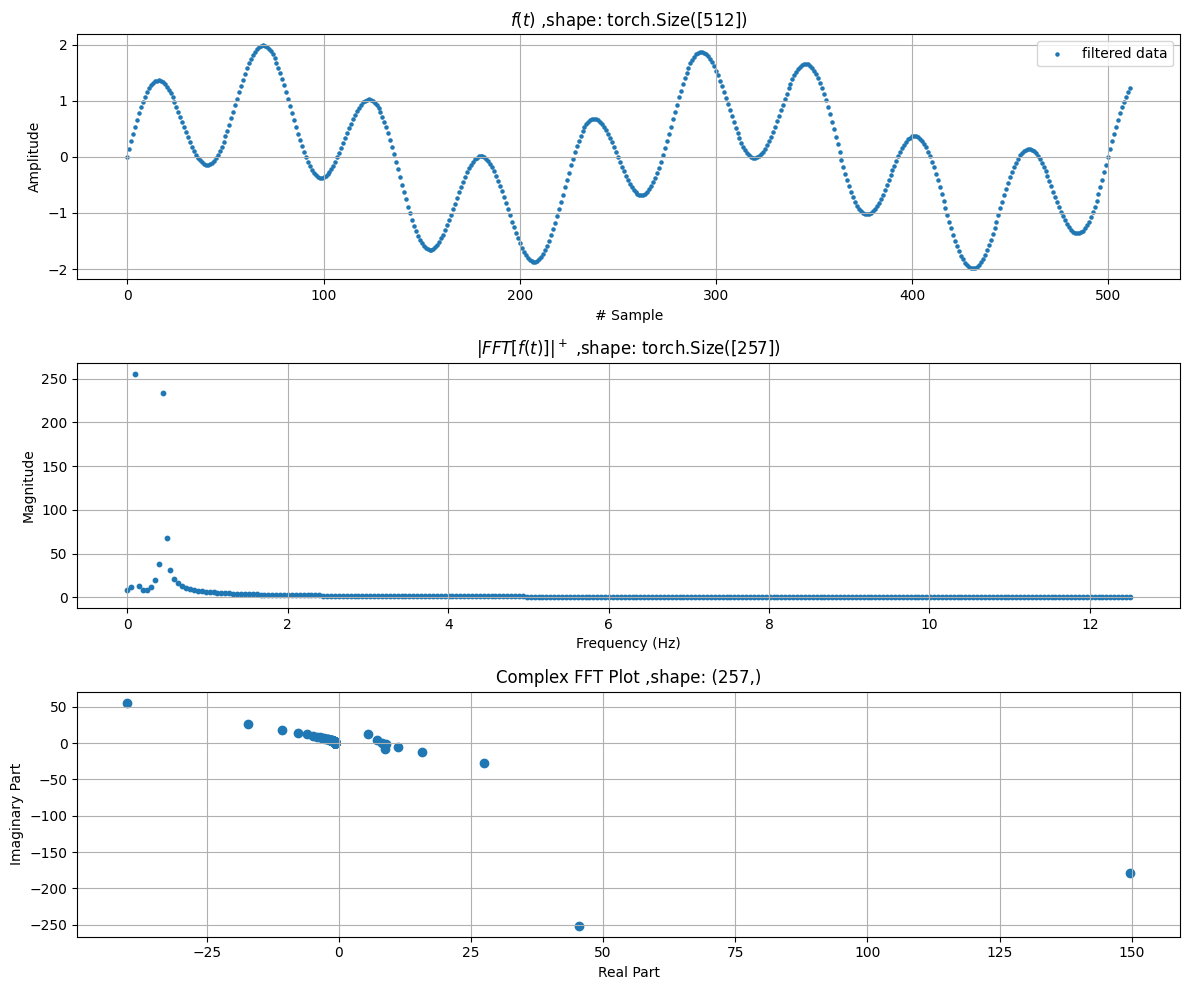

In [14]:
import matplotlib

# matplotlib.use('TkAgg')
plt.figure(figsize=(12, 10))

# Subplot 1: Input signal
plt.subplot(3, 1, 1)
plt.scatter(torch.arange(len(dataset.data)), dataset.data, s=5, label='filtered data')
plt.title(r'$f(t)$' + ' ,shape: ' + str(dataset.data.shape)), plt.xlabel('# Sample'), plt.ylabel('Amplitude')
plt.grid(), plt.legend()

# Subplot 2: FFT
plt.subplot(3, 1, 2)
plt.scatter(dataset.fft['freqs'], dataset.fft['magnitude'], s=10, label='FFT[filtered data]')
plt.title(r'$|FFT[f(t)]|^+$' + ' ,shape: ' + str(dataset.fft['fft'].shape)), plt.xlabel('Frequency (Hz)'), plt.ylabel(
    'Magnitude'), plt.grid()

plt.subplot(3, 1, 3)
complex_fft = dataset.fft['fft'].numpy()

# Plot complex FFT values as lines
plt.scatter(dataset.fft['fft'].real, dataset.fft['fft'].imag)
plt.title('Complex FFT Plot' + ' ,shape: ' + str(complex_fft.shape)), plt.xlabel('Real Part'), plt.ylabel(
    'Imaginary Part')
plt.grid()

# # Subplot 3: Spectrogram
# plt.subplot(3, 1, 3)
# stft_np = dataset.stft.numpy()
# plt.imshow(stft_np, aspect='auto', cmap='viridis', origin='lower', extent=[0, stft_np.shape[1], 0, fs / 2])
# plt.colorbar(label='Magnitude')
# plt.title('Spectrogram' + ' ,shape: ' + str(dataset.stft.shape)), plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
# # plt.ylim(0, max(top_k_freqs) + 100)
# # plt.ylim(0,30)
plt.tight_layout()
plt.show()



## Test FFT with low pass filter + padding to IFFT

In [23]:
print('Original shape: ', multifeature.shape)
regular_fft = torch.fft.rfft(multifeature, dim=0)
print('Regular FFT shape: ', regular_fft.shape)
regular_ifft = torch.fft.irfft(regular_fft, dim=0)
print('Regular IFFT shape: ', regular_ifft.shape)
print('=' * 50)
filtered_fft = regular_fft[:10, :]  # 50 is the number of frequencies we want to keep
print('Filtered FFT shape: ', filtered_fft.shape)
padded_filtered_fft = torch.nn.functional.pad(filtered_fft, (0, 0, 0, (len(multifeature) // 2 + 1) - len(filtered_fft)))
print('Zero Padded Filtered FFT shape: ', padded_filtered_fft.shape)
padded_filtered_ifft = torch.fft.irfft(padded_filtered_fft, dim=0)
print('IFFT shape: ', padded_filtered_ifft.shape)
reconstructed = torch.fft.irfft(padded_filtered_fft, dim=0)
print('Reconstructed shape: ', reconstructed.shape)

Original shape:  torch.Size([512, 3])
Regular FFT shape:  torch.Size([257, 3])
Regular IFFT shape:  torch.Size([512, 3])
Filtered FFT shape:  torch.Size([10, 3])
Zero Padded Filtered FFT shape:  torch.Size([257, 3])
IFFT shape:  torch.Size([512, 3])
Reconstructed shape:  torch.Size([512, 3])


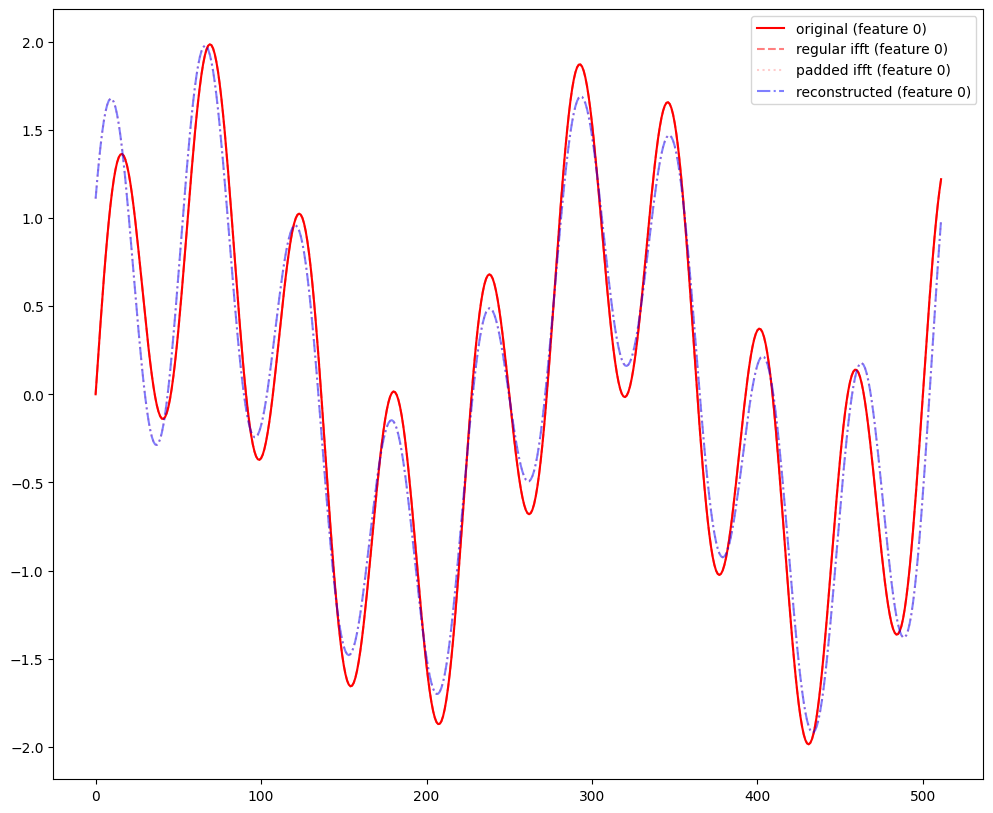

In [25]:
# two plots, one for the regular ifft and one for the ifft on the padded data:
plt.figure(figsize=(12, 10))
plt.plot(multifeature[:, 0].numpy(), label='original (feature 0)', color='red')
# plt.plot(multifeature[:,1].numpy(),label='original (feature 1)',color='green')
# plt.plot(multifeature[:,2].numpy(),label='original (feature 2)',color='blue')
# lighter colors:

plt.plot(regular_ifft[:, 0].numpy(), label='regular ifft (feature 0)', color='red', linestyle='--', alpha=0.5)
# plt.plot(regular_ifft[:,1].numpy(),label='regular ifft (feature 1)',color='green', linestyle='--',alpha=0.5)
# plt.plot(regular_ifft[:,2].numpy(),label='regular ifft (feature 2)',color='blue', linestyle='--',alpha=0.5)

plt.plot(padded_filtered_ifft[:, 0].numpy(), label='padded ifft (feature 0)', linestyle=':', color='red', alpha=0.2)
# plt.plot(padded_filtered_ifft[:,1].numpy(),label='padded ifft (feature 1)', linestyle=':',color='green',alpha=0.2)
# plt.plot(padded_filtered_ifft[:,2].numpy(),label='padded ifft (feature 2)',	linestyle=':',color='blue',alpha=0.2)

plt.plot(reconstructed[:, 0].numpy(), label='reconstructed (feature 0)', linestyle='-.', color='blue', alpha=0.5)
plt.legend()
plt.show()


## Sin + Cos encoding

In [17]:
def sin_encoding(data):
    return torch.sin(2 * np.pi * data / (2*np.pi))


def cos_encoding(data):
    return torch.cos(2 * np.pi * data / (2*np.pi))

In [18]:
hours_of_the_week = torch.tensor([i for i in range(24)] * 7)
_sin = sin_encoding(hours_of_the_week)
_cos = cos_encoding(hours_of_the_week)

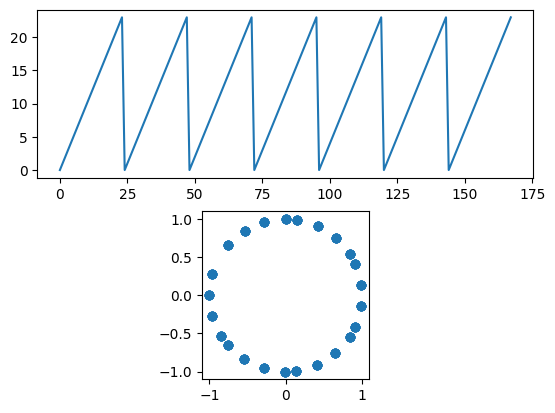

In [19]:
plt.subplot(2, 1, 1)
plt.plot(hours_of_the_week,label='hours of the week')
plt.subplot(2, 1, 2)
plt.scatter(_sin,_cos,label='sin-cos encoding')
# square plot:

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [20]:
random_angles_in_radians = torch.rand(1000) * 2 * np.pi
_sin = sin_encoding(random_angles_in_radians)
_cos = cos_encoding(random_angles_in_radians)

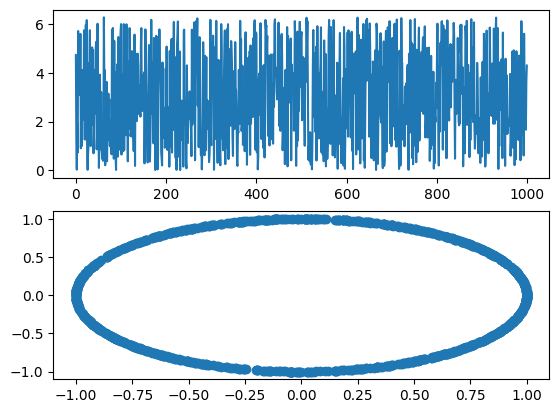

In [21]:
plt.subplot(2, 1, 1)
plt.plot(random_angles_in_radians,label='random angles in radians')
plt.subplot(2, 1, 2)
plt.scatter(_sin,_cos,label='sin-cos encoding')
plt.show()

## Test the scale preserving property of fft and ifft

In [ ]:
print('Original shape: ', multifeature.shape)
regular_fft = torch.fft.rfft(multifeature, dim=0)
print('Regular FFT shape: ', regular_fft.shape)
regular_ifft = torch.fft.irfft(regular_fft, dim=0)
print('Regular IFFT shape: ', regular_ifft.shape)
print('=' * 50)
filtered_fft = regular_fft[:10, :]  # 50 is the number of frequencies we want to keep
print('Filtered FFT shape: ', filtered_fft.shape)
padded_filtered_fft = torch.nn.functional.pad(filtered_fft, (0, 0, 0, (len(multifeature) // 2 + 1) - len(filtered_fft)))
print('Zero Padded Filtered FFT shape: ', padded_filtered_fft.shape)
padded_filtered_ifft = torch.fft.irfft(padded_filtered_fft, dim=0)
print('IFFT shape: ', padded_filtered_ifft.shape)